(sec:sgd)=
# Optimisation

Dans ce chapitre, nous présenterons des variantes de la stratégie d'optimisation **de descente de gradient** et montrerons comment elles peuvent être utilisées pour optimiser les paramètres des réseaux de neurones.

Commençons par l'algorithme de base de la descente de gradient et ses limites.

```{prf:algorithm} Descente de Gradient
:label: algo:gd

**Entrée:** Un jeu de données $\mathcal{D} = (X, y)$

1. Initialiser les paramètres $\theta$ du modèle
2. for $e = 1 .. E$

    1. for $(x_i, y_i) \in \mathcal{D}$

        1. Calculer la prédiction $\hat{y}_i = m_\theta(x_i)$
        2. Calculer le gradient individuel $\nabla_\theta \mathcal{L}_i$

    2. Calculer le gradient total $\nabla_\theta \mathcal{L} = \frac{1}{n} \sum_i \nabla_\theta \mathcal{L}_i$
    3. Mettre à jour les paramètres $\theta$ à partir de $\nabla_\theta \mathcal{L}$
```

La règle de mise à jour typique pour les paramètres $\theta$ à l'itération $t$ est

$$
    \theta^{(t+1)} \leftarrow \theta^{(t)} - \rho \nabla_\theta \mathcal{L}
$$

où $\rho$ est un hyper-paramètre important de la méthode, appelé le taux d'apprentissage (ou _learning rate_).
La descente de gradient consiste à jour itérativement $\theta$ dans la direction de la plus forte diminution de la perte $\mathcal{L}$.

Comme on peut le voir dans l'algorithme précédent, lors d'un descente de gradient, les paramètres du modèle sont mis à jour une fois par _epoch_, ce qui signifie qu'un passage complet sur l'ensemble des données est nécessaire avant la mise à jour.
Lorsque l'on traite de grands jeux de données, cela constitue une forte limitation, ce qui motive l'utilisation de variantes stochastiques.

## Descente de gradient stochastique

L'idée derrière l'algorithme de descente de gradient stochastique (ou _Stochastic Gradient Descent_, SGD) est d'obtenir des estimations bon marché (au sens de la quantité de calculs nécessaires) pour la quantité

$$
    \nabla_\theta \mathcal{L}(\mathcal{D} ; m_\theta) = \frac{1}{n} \sum_{(x_i, y_i) \in \mathcal{D}} \nabla_\theta \mathcal{L}(x_i, y_i ; m_\theta)
$$

où $\mathcal{D}$ est l'ensemble d'apprentissage.
Pour ce faire, on tire des sous-ensembles de données, appelés _minibatchs_, et

$$
    \nabla_\theta \mathcal{L}(\mathcal{B} ; m_\theta) = \frac{1}{b} \sum_{(x_i, y_i) \in \mathcal{B}} \nabla_\theta \mathcal{L}(x_i, y_i ; m_\theta)
$$
est utilisé comme estimateur de $\nabla_\theta \mathcal{L}(\mathcal{D} ; m_\theta)$.
Il en résulte l'algorithme suivant dans lequel les mises à jour des paramètres se produisent après chaque _minibatch_, c'est-à-dire plusieurs fois par _epoch_.

```{prf:algorithm} Descente de gradient stochastique
:label: algo:sgd

**Input:** A dataset $\mathcal{D} = (X, y)$

1. Initialiser les paramètres $\theta$ du modèle
2. for $e = 1 .. E$

    1. for $t = 1 .. n_\text{minibatches}$

        1. Tirer un échantillon aléatoire de taillle $b$ dans $\mathcal{D}$ que l'on appelle _minibatch_
        1. for $(x_i, y_i) \in \mathcal{B}$

            1. Calculer la prédiction $\hat{y}_i = m_\theta(x_i)$
            2. Calculer le gradient individuel $\nabla_\theta \mathcal{L}_i$

        2. Calculer le gradient sommé sur le _minibatch_ $\nabla_\theta \mathcal{L}_{\mathcal{B}} = \frac{1}{b} \sum_i \nabla_\theta \mathcal{L}_i$
        3. Mettre à jour les paramètres $\theta$ à partir de $\nabla_\theta \mathcal{L}_{\mathcal{B}}$
```

Par conséquent, lors de l'utilisation de SGD, les mises à jour des paramètres sont plus fréquentes, mais elles sont "bruitées" puisqu'elles sont basées sur une estimation du gradient par _minibatch_ au lieu de s'appuyer sur le vrai gradient, comme illustré ci-dessous :

In [1]:
import numpy as np

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import scipy.optimize as optim
from notebook_utils import prepare_notebook_graphics
prepare_notebook_graphics()

def grad(X, y, alpha, lambd):
    p = np.exp(-y * X.dot(alpha))
    d = - X.T.dot(p * y / (1 + p)) + lambd * alpha
    return d

def norm(x):
    return np.sqrt(np.sum(x ** 2))

def cost(X, y, alpha, lambd):
    p = np.exp(-y * X.dot(alpha))
    return np.sum(np.log(1 + p)) + .5 * lambd * norm(alpha) ** 2
    # TODO: 1/n pour pas que le SGD fasse nimp


def optim_gd(X, y, alpha_init, n_epochs, lambd, rho):
    alphas = [alpha_init]
    for _ in range(n_epochs):
        d = - grad(X, y, alphas[-1], lambd)        
        alphas.append(alphas[-1] + rho * d)

    return np.concatenate(alphas, axis=0).reshape((-1, alpha_init.shape[0]))


def optim_sgd(X, y, alpha_init, n_epochs, lambd, rho, minibatch_size):
    alphas = [alpha_init]
    for i in range(n_epochs):
        for j in range(X.shape[0] // minibatch_size):
            scaled_lambda = lambd / (X.shape[0] // minibatch_size)
            indices_minibatch = np.random.randint(X.shape[0], size=minibatch_size)
            X_minibatch = X[indices_minibatch]
            y_minibatch = y[indices_minibatch]
            d = - grad(X_minibatch, y_minibatch, alphas[-1], scaled_lambda)
              
            alphas.append(alphas[-1] + rho * d)

    return np.concatenate(alphas, axis=0).reshape((-1, alpha_init.shape[0]))


def stretch_to_range(lim, sz_range):
    middle = (lim[0] + lim[1]) / 2
    return [middle - sz_range / 2, middle + sz_range / 2]


def get_lims(*alphas_list):
    xlims = [
        min([alphas[:, 0].min() for alphas in alphas_list]) - 1,
        max([alphas[:, 0].max() for alphas in alphas_list]) + 1
    ]
    ylims = [
        min([alphas[:, 1].min() for alphas in alphas_list]) - 1,
        max([alphas[:, 1].max() for alphas in alphas_list]) + 1
    ]
    if xlims[1] - xlims[0] > ylims[1] - ylims[0]:
        ylims = stretch_to_range(ylims, xlims[1] - xlims[0])
    else:
        xlims = stretch_to_range(xlims, ylims[1] - ylims[0])
    return xlims, ylims


def gen_anim(X, y, alphas_gd, alphas_sgd, alpha_star, lambd, xlims, ylims, n_steps_per_epoch, gen_video=True):
    global lines_alphas

    n = 40
    nn = n * n
    xv, yv = np.meshgrid(np.linspace(xlims[0], xlims[1], n),
                         np.linspace(ylims[0], ylims[1], n))
    xvisu = np.concatenate((xv.ravel()[:, None], yv.ravel()[:, None]), axis=1)

    pv = np.zeros(nn)
    for i in range(nn):
        pv[i] = cost(X, y, xvisu[i], lambd)

    P = pv.reshape((n,n))
    
    fig = plt.figure(figsize=(13, 6))
    axes = [plt.subplot(1, 2, i + 1) for i in range(2)]

    lines_alphas = []
    texts = []  
    for ax, alphas, title in zip(axes, 
                                 [alphas_gd, alphas_sgd],
                                 ["Descente de Gradient", "Descente de Gradient Stochastique"]):
        ax.contour(xv, yv, P, alpha=0.5)
        ax.plot(alphas[0, 0], alphas[0, 1], 'ko', fillstyle='none')
        line_alphas,  = ax.plot(alphas[:1, 0], alphas[:1, 1], marker="x")
        lines_alphas.append(line_alphas)
        
        ax.plot(alpha_star[0:1], alpha_star[1:2], '+r')

        ax.set_xlabel("$w_0$")
        ax.set_ylabel("$w_1$")
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(title)
        text_epoch = ax.text(0.7 * xlims[1], 0.8 * ylims[1], s="Epoch 0")
        texts.append(text_epoch)

    def animate(i):
        global lines_alphas
        
        for line_alphas, text_epoch, alphas in zip(lines_alphas, texts, [alphas_gd, alphas_sgd]):
            line_alphas.set_xdata(alphas[:i, 0])
            line_alphas.set_ydata(alphas[:i, 1])
            
            text_epoch.set_text(f"Epoch {i // n_steps_per_epoch}")
        return lines_alphas + texts
    
    if gen_video:
        ani = animation.FuncAnimation(fig, animate, interval=500, blit=False, save_count=len(alphas_gd))
        return HTML(ani.to_jshtml())
    else:
        animate(len(alphas_gd))
        return fig


# Data

np.random.seed(0)
X = np.random.rand(20, 2) * 3 - 1.5
y = (X[:, 0] > 0.).astype(int)
y[y == 0] = -1

# Optim

lambd = .1
rho = 2e-1
alpha_init = np.array([1., -3.])
n_epochs = 10
minibatch_size = 4

res_optim = optim.minimize(fun=lambda alpha: cost(X, y, alpha, lambd),
                           x0=alpha_init, 
                           jac=lambda alpha: grad(X, y, alpha, lambd))
alpha_star = res_optim["x"]

alphas_gd = optim_gd(X, y, alpha_init, n_epochs, lambd, rho)
alphas_sgd = optim_sgd(X, y, alpha_init, n_epochs, lambd, rho, minibatch_size)

# Visualization
xlims, ylims = get_lims(alphas_gd, alphas_sgd, np.array([alpha_star]))

is_html_output = True
viz = gen_anim(X, y, 
               np.repeat(alphas_gd, 20 // minibatch_size, axis=0), alphas_sgd,
               alpha_star, lambd, xlims, ylims, 
               n_steps_per_epoch=20 // minibatch_size, gen_video=is_html_output)
plt.close()

viz

Outre le fait qu'elle implique des mises à jour plus fréquentes des paramètres, la SGD présente un avantage supplémentaire en termes d'optimisation, qui est essentiel pour les réseaux de neurones.
En effet, comme on peut le voir ci-dessous, contrairement à ce que nous avions dans le cas du Perceptron, la perte MSE (et il en va de même pour la perte logistique) n'est plus convexe en les paramètres du modèle dès que celui-ci possède au moins une couche cachée :

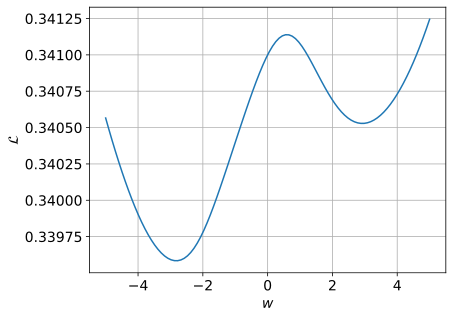

In [2]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def model_forward_loss(weights, biases, X, y):
    outputs = X
    for w, b in zip(weights, biases):
        outputs = sigmoid(outputs @ w + b)
    loss = np.mean((outputs - y) ** 2)
    loss += .0001 * np.sum([(w ** 2).sum() for w in weights])
    return loss


np.random.seed(0)
w0 = np.linspace(-5, 5, 100)
X = np.random.randn(150, 6)
y = np.array([0] * 75 + [1] * 75)
weights = [
    np.random.randn(6, 20),
    np.random.randn(20, 1)
]
biases = [
    np.random.randn(1, 20),
    np.random.randn(1, 1)
]

losses = []
for wi in w0:
    weights[0][3, 9] = wi
    losses.append(model_forward_loss(weights, biases, X, y))


plt.plot(w0, losses)
plt.grid('on')
plt.xlabel('$w$')
plt.ylabel('$\mathcal{L}$');

La descente de gradient est connue pour souffrir d'optima locaux, et de tels fonctions de pertes constituent un problème sérieux pour la descente de gradient.
D'un autre côté, la descente de gradient stochastique est susceptible de bénéficier d'estimations de gradient bruitées pour s'échapper des minima locaux.

## Une note sur Adam

Adam {cite}`2015-kingma` est une variante de la méthode de descente de gradient stochastique.
Elle diffère dans la règle de mise à jour des paramètres.

Tout d'abord, elle utilise ce qu'on appelle le momentum, qui consiste essentiellement à s'appuyer sur les mises à jour antérieures du gradient pour lisser la trajectoire dans l'espace des paramètres pendant l'optimisation.
Une illustration interactive du momentum peut être trouvée dans {cite}`goh2017why`.

L'estimation du gradient est remplacée par la quantité :

$$
  \mathbf{m}^{(t+1)} \leftarrow \frac{1}{1 - \beta_1^t} \left[\beta_1 \mathbf{m}^{(t)} + (1 - \beta_1) \nabla_\theta \mathcal{L} \right]
$$

Lorsque $\beta_1$ est égal à zéro, nous avons $\mathbf{m}^{(t+1)} = \nabla_\theta \mathcal{L}$ et pour $\beta_1 \in ]0, 1[$, $\mathbf{m}^{(t+1)}$ l'estimation courante du gradient utilise l'information sur les estimations passées, stockée dans $\mathbf{m}^{(t)}$.

Une autre différence importante entre SGD et la Adam consiste à utiliser un taux d'apprentissage adaptatif.
En d'autres termes, au lieu d'utiliser le même taux d'apprentissage $\rho$ pour tous les paramètres du modèle, le taux d'apprentissage pour un paramètre donné $\theta_i$ est défini comme :

$$
  \hat{\rho}^{(t+1)}(\theta_i) = \frac{\rho}{\sqrt{s^{(t+1)}(\theta_i)+\epsilon}}
$$

où $\epsilon$ est une constante petite devant 1 et 

$$
  s^{(t+1)}(\theta_i) = \frac{1}{1 - \beta_2^t} \left[ \beta_{2} s^{(t)}(\theta_i) + (1-\beta_{2}) \left(\nabla_{\theta_i} \mathcal{L}\right)^2\right]
$$

Ici aussi, le terme $s$ utilise le momentum. Par conséquent, le taux d'apprentissage sera réduit pour les paramètres qui ont subi de grandes mises à jour dans les itérations précédentes.

Globalement, la règle de mise à jour d'Adam est la suivante :

$$
  \theta^{(t+1)} \leftarrow \theta^{(t)} - \hat{\rho}^{(t+1)}(\theta) \mathbf{m}^{(t+1)}
$$

## La malédiction de la profondeur

Considérons le réseau neuronal suivant :

```{tikz}
    \tikzset{every path/.style={line width=1pt}}

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in0) at  (0, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in1) at  (0, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in2) at  (0, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in3) at  (0, 1) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in4) at  (0, 0) {};

    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_0) at  (3, 5) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_1) at  (3, 4) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_2) at  (3, 3) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_3) at  (3, 2) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_4) at  (3, 1) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_5) at  (3, 0) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_6) at  (3, -1) {};

    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_0) at  (6, 5) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_1) at  (6, 4) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_2) at  (6, 3) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_3) at  (6, 2) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_4) at  (6, 1) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_5) at  (6, 0) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_6) at  (6, -1) {};
    
    \node[draw=blue, circle, minimum size=17pt,inner sep=0pt] (out_0) at  (9, 1) {};
    \node[draw=blue, circle, minimum size=17pt,inner sep=0pt] (out_1) at  (9, 2) {};
    \node[draw=blue, circle, minimum size=17pt,inner sep=0pt] (out_2) at  (9, 3) {};

    \draw[->, color=red] (in0) -- (h1_0);
    \draw[->, color=red] (in0) -- (h1_1);
    \draw[->, color=red] (in0) -- (h1_2);
    \draw[->, color=red] (in0) -- (h1_3);
    \draw[->, color=red] (in0) -- (h1_4);
    \draw[->, color=red] (in0) -- (h1_5);
    \draw[->, color=red] (in0) -- (h1_6);
    \draw[->, color=red] (in1) -- (h1_0);
    \draw[->, color=red] (in1) -- (h1_1);
    \draw[->, color=red] (in1) -- (h1_2);
    \draw[->, color=red] (in1) -- (h1_3);
    \draw[->, color=red] (in1) -- (h1_4);
    \draw[->, color=red] (in1) -- (h1_5);
    \draw[->, color=red] (in1) -- (h1_6);
    \draw[->, color=red] (in2) -- (h1_0);
    \draw[->, color=red] (in2) -- (h1_1);
    \draw[->, color=red] (in2) -- (h1_2);
    \draw[->, color=red] (in2) -- (h1_3);
    \draw[->, color=red] (in2) -- (h1_4);
    \draw[->, color=red] (in2) -- (h1_5);
    \draw[->, color=red] (in2) -- (h1_6);
    \draw[->, color=red] (in3) -- (h1_0);
    \draw[->, color=red] (in3) -- (h1_1);
    \draw[->, color=red] (in3) -- (h1_2);
    \draw[->, color=red] (in3) -- (h1_3);
    \draw[->, color=red] (in3) -- (h1_4);
    \draw[->, color=red] (in3) -- (h1_5);
    \draw[->, color=red] (in3) -- (h1_6);
    \draw[->, color=red] (in4) -- (h1_0);
    \draw[->, color=red] (in4) -- (h1_1);
    \draw[->, color=red] (in4) -- (h1_2);
    \draw[->, color=red] (in4) -- (h1_3);
    \draw[->, color=red] (in4) -- (h1_4);
    \draw[->, color=red] (in4) -- (h1_5);
    \draw[->, color=red] (in4) -- (h1_6);

    \draw[->, color=purple] (h1_0) -- (h2_0);
    \draw[->, color=purple] (h1_1) -- (h2_0);
    \draw[->, color=purple] (h1_2) -- (h2_0);
    \draw[->, color=purple] (h1_3) -- (h2_0);
    \draw[->, color=purple] (h1_4) -- (h2_0);
    \draw[->, color=purple] (h1_5) -- (h2_0);
    \draw[->, color=purple] (h1_6) -- (h2_0);
    \draw[->, color=purple] (h1_0) -- (h2_1);
    \draw[->, color=purple] (h1_1) -- (h2_1);
    \draw[->, color=purple] (h1_2) -- (h2_1);
    \draw[->, color=purple] (h1_3) -- (h2_1);
    \draw[->, color=purple] (h1_4) -- (h2_1);
    \draw[->, color=purple] (h1_5) -- (h2_1);
    \draw[->, color=purple] (h1_6) -- (h2_1);
    \draw[->, color=purple] (h1_0) -- (h2_2);
    \draw[->, color=purple] (h1_1) -- (h2_2);
    \draw[->, color=purple] (h1_2) -- (h2_2);
    \draw[->, color=purple] (h1_3) -- (h2_2);
    \draw[->, color=purple] (h1_4) -- (h2_2);
    \draw[->, color=purple] (h1_5) -- (h2_2);
    \draw[->, color=purple] (h1_6) -- (h2_2);
    \draw[->, color=purple] (h1_0) -- (h2_3);
    \draw[->, color=purple] (h1_1) -- (h2_3);
    \draw[->, color=purple] (h1_2) -- (h2_3);
    \draw[->, color=purple] (h1_3) -- (h2_3);
    \draw[->, color=purple] (h1_4) -- (h2_3);
    \draw[->, color=purple] (h1_5) -- (h2_3);
    \draw[->, color=purple] (h1_6) -- (h2_3);
    \draw[->, color=purple] (h1_0) -- (h2_4);
    \draw[->, color=purple] (h1_1) -- (h2_4);
    \draw[->, color=purple] (h1_2) -- (h2_4);
    \draw[->, color=purple] (h1_3) -- (h2_4);
    \draw[->, color=purple] (h1_4) -- (h2_4);
    \draw[->, color=purple] (h1_5) -- (h2_4);
    \draw[->, color=purple] (h1_6) -- (h2_4);
    \draw[->, color=purple] (h1_0) -- (h2_5);
    \draw[->, color=purple] (h1_1) -- (h2_5);
    \draw[->, color=purple] (h1_2) -- (h2_5);
    \draw[->, color=purple] (h1_3) -- (h2_5);
    \draw[->, color=purple] (h1_4) -- (h2_5);
    \draw[->, color=purple] (h1_5) -- (h2_5);
    \draw[->, color=purple] (h1_6) -- (h2_5);
    \draw[->, color=purple] (h1_0) -- (h2_6);
    \draw[->, color=purple] (h1_1) -- (h2_6);
    \draw[->, color=purple] (h1_2) -- (h2_6);
    \draw[->, color=purple] (h1_3) -- (h2_6);
    \draw[->, color=purple] (h1_4) -- (h2_6);
    \draw[->, color=purple] (h1_5) -- (h2_6);
    \draw[->, color=purple] (h1_6) -- (h2_6);

    \draw[->, color=blue] (h2_0) -- (out_0);
    \draw[->, color=blue] (h2_1) -- (out_0);
    \draw[->, color=blue] (h2_2) -- (out_0);
    \draw[->, color=blue] (h2_3) -- (out_0);
    \draw[->, color=blue] (h2_4) -- (out_0);
    \draw[->, color=blue] (h2_5) -- (out_0);
    \draw[->, color=blue] (h2_6) -- (out_0);
    \draw[->, color=blue] (h2_0) -- (out_1);
    \draw[->, color=blue] (h2_1) -- (out_1);
    \draw[->, color=blue] (h2_2) -- (out_1);
    \draw[->, color=blue] (h2_3) -- (out_1);
    \draw[->, color=blue] (h2_4) -- (out_1);
    \draw[->, color=blue] (h2_5) -- (out_1);
    \draw[->, color=blue] (h2_6) -- (out_1);
    \draw[->, color=blue] (h2_0) -- (out_2);
    \draw[->, color=blue] (h2_1) -- (out_2);
    \draw[->, color=blue] (h2_2) -- (out_2);
    \draw[->, color=blue] (h2_3) -- (out_2);
    \draw[->, color=blue] (h2_4) -- (out_2);
    \draw[->, color=blue] (h2_5) -- (out_2);
    \draw[->, color=blue] (h2_6) -- (out_2);


    \node[fill=white, text=red] (beta0) at  (1.5, 2) {$\mathbf{w^{(0)}}$};
    \node[fill=white, text=purple] (beta1) at  (4.5, 2) {$\mathbf{w^{(1)}}$};
    \node[fill=white, text=blue] (beta2) at  (7.5, 2) {$\mathbf{w^{(2)}}$};
```

et rappelons que, pour une couche donnée $(\ell)$, la sortie de la couche est calculée comme suit

$$
  a^{(\ell)} = \varphi(o^{(\ell)}) = \varphi(w^{(\ell - 1)} a^{(\ell - 1)})
$$

où $\varphi$ est la fonction d'activation pour la couche donnée (nous ignorons les termes de biais dans cet exemple simplifié).

Afin d'effectuer une descente de gradient (stochastique), les gradients de la perte par rapport aux paramètres du modèle doivent être calculés.

En utilisant la règle de la dérivation en chaîne, ces gradients peuvent être exprimés comme suit :

\begin{align*}
  \frac{\partial \mathcal{L}}{\partial w^{(2)}} &= \frac{\partial \mathcal{L}}{\partial a^{(3)}}
{\color{blue}\frac{\partial a^{(3)}}{\partial o^{(3)}} \frac{\partial o^{(3)}}{\partial w^{(2)}}} \\
  \frac{\partial \mathcal{L}}{\partial w^{(1)}} &= \frac{\partial \mathcal{L}}{\partial a^{(3)}}
{\color{blue}\frac{\partial a^{(3)}}{\partial o^{(3)}} \frac{\partial o^{(3)}}{\partial a^{(2)}}}
{\color{purple}\frac{\partial a^{(2)}}{\partial o^{(2)}} \frac{\partial o^{(2)}}{\partial w^{(1)}}} \\
  \frac{\partial \mathcal{L}}{\partial w^{(0)}} &= \frac{\partial \mathcal{L}}{\partial a^{(3)}}
{\color{blue}\frac{\partial a^{(3)}}{\partial o^{(3)}} \frac{\partial o^{(3)}}{\partial a^{(2)}}}
{\color{purple}\frac{\partial a^{(2)}}{\partial o^{(2)}} \frac{\partial o^{(2)}}{\partial a^{(1)}}}
{\color{red}\frac{\partial a^{(1)}}{\partial o^{(1)}} \frac{\partial o^{(1)}}{\partial w^{(0)}}}
\end{align*}

Il y a des idées importantes à saisir ici.

Tout d'abord, il faut remarquer que les poids qui sont plus éloignés de la sortie du modèle héritent de règles de gradient composées de plus de termes.
Par conséquent, lorsque certains de ces termes deviennent de plus en plus petits, il y a un risque plus élevé pour ces poids que leurs gradients tombent à 0. C'est ce qu'on appelle l'effet de **gradient évanescent** (_vanishing gradient_), qui est un phénomène très courant dans les réseaux neuronaux profonds (c'est-à-dire les réseaux composés de nombreuses couches).

Deuxièmement, certains termes sont répétés dans ces formules, et en général, des termes de la forme $\frac{\partial a^{(\ell)}}{\partial o^{(\ell)}}$ et $\frac{\partial o^{(\ell)}}{\partial a^{(\ell-1)}}$ sont présents à plusieurs endroits.
Ces termes peuvent être développés comme suit :

\begin{align*}
  \frac{\partial a^{(\ell)}}{\partial o^{(\ell)}} &= \varphi^\prime (o^{(\ell)}) \\
  \frac{\partial o^{(\ell)}}{\partial a^{(\ell - 1)}} &= w^{(\ell - 1)}
\end{align*}

Voyons à quoi ressemblent les dérivées des fonctions d'activation standard :

2023-08-21 16:06:16.166527: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 16:06:16.227448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 16:06:16.229237: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-08-21 16:06:17.440470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


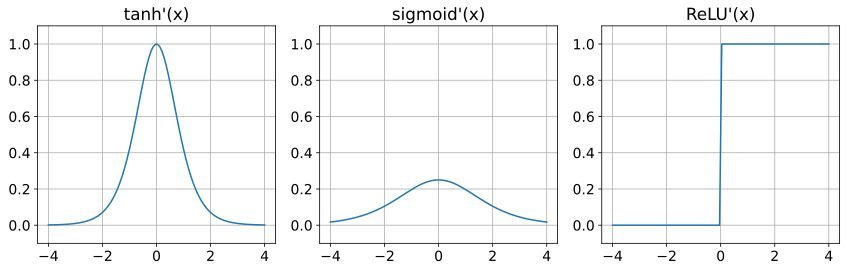

In [3]:
import tensorflow as tf

def tanh(x):
    return 2. / (1. + tf.exp(-2 * x)) - 1.

def sigmoid(x):
    return 1. / (1. + tf.exp(-x))


x = tf.Variable(tf.linspace(-4, 4, 100))
with tf.GradientTape() as tape_grad:
    tan_x = tanh(x)
with tf.GradientTape() as tape_sig:
    sig_x = sigmoid(x)
with tf.GradientTape() as tape_relu:
    relu_x = tf.nn.relu(x)

grad_tanh_x = tape_grad.gradient(tan_x, x)
grad_sig_x = tape_sig.gradient(sig_x, x)
grad_relu_x = tape_relu.gradient(relu_x, x)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(x.numpy(), grad_tanh_x)
plt.grid('on')
plt.ylim([-.1, 1.1])
plt.title("tanh'(x)")

plt.subplot(1, 3, 2)
plt.plot(x.numpy(), grad_sig_x)
plt.grid('on')
plt.ylim([-.1, 1.1])
plt.title("sigmoid'(x)")

plt.subplot(1, 3, 3)
plt.plot(x.numpy(), grad_relu_x)
plt.grid('on')
plt.ylim([-.1, 1.1])
plt.title("ReLU'(x)")

plt.tight_layout();

On peut constater que la dérivée de ReLU possède une plus grande plage de valeurs d'entrée pour lesquelles elle est non nulle (typiquement toute la plage de valeurs d'entrée positives) que ses concurrentes, ce qui en fait une fonction d'activation très intéressante pour les réseaux neuronaux profonds, car nous avons vu que le terme $\frac{\partial a^{(\ell)}}{\partial o^{(\ell)}}$ apparaît de manière répétée dans les dérivations en chaîne.

## Coder tout cela en `keras`

Dans `keras`, les informations sur les pertes et l'optimiseur sont transmises au moment de la compilation :

In [4]:
import keras_core as keras
from keras.layers import Dense, InputLayer
from keras.models import Sequential

model = Sequential([
    InputLayer(input_shape=(10, )),
    Dense(units=20, activation="relu"),
    Dense(units=3, activation="softmax")
])

model.summary()

Using TensorFlow backend


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 20)                220       


 dense_1 (Dense)             (None, 3)                 63        


Total params: 283 (1.11 KB)


Trainable params: 283 (1.11 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

En termes de pertes :

* `"mse"` est la perte d'erreur quadratique moyenne,
* `"binary_crossentropy"` est la perte logistique pour la classification binaire,
* `"categorical_crossentropy"` est la perte logistique pour la classification multi-classes.

Les optimiseurs définis dans cette section sont disponibles sous forme de `"sgd"` et `"adam"`.
Afin d'avoir le contrôle sur les hyper-paramètres des optimiseurs, on peut alternativement utiliser la syntaxe suivante :

In [6]:
from keras.optimizers import Adam, SGD

# Not a very good idea to tune beta_1 
# and beta_2 parameters in Adam
adam_opt = Adam(learning_rate=0.001, 
                beta_1=0.9, beta_2=0.9)

# In order to use SGD with a custom learning rate:
# sgd_opt = SGD(learning_rate=0.001)

model.compile(loss="categorical_crossentropy", optimizer=adam_opt)

## Prétraitement des données

En pratique, pour que la phase d'ajustement du modèle se déroule correctement, il est important de mettre à l'échelle les données d'entrée. 
Dans l'exemple suivant, nous allons comparer deux entraînements du même modèle, avec une initialisation similaire et la seule différence entre les deux sera de savoir si les données d'entrée sont centrées-réduites ou laissées telles quelles.

In [7]:
import pandas as pd
from keras.utils import to_categorical

iris = pd.read_csv("../data/iris.csv", index_col=0)
iris = iris.sample(frac=1)
y = to_categorical(iris["target"])
X = iris.drop(columns=["target"])

In [8]:
from keras.layers import Dense, InputLayer
from keras.models import Sequential
from keras.utils import set_random_seed


set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, epochs=n_epochs, batch_size=30, verbose=0)

Standardisons maintenant nos données et comparons les performances obtenues :

In [9]:

X -= X.mean(axis=0)
X /= X.std(axis=0)


set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h_standardized = model.fit(X, y, epochs=n_epochs, batch_size=30, verbose=0)

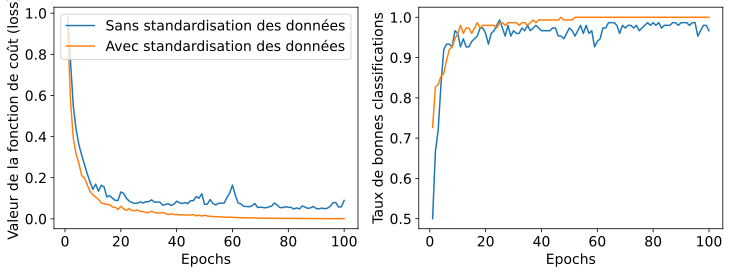

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs + 1), h.history["loss"], label="Sans standardisation des données")
plt.plot(np.arange(1, n_epochs + 1), h_standardized.history["loss"], label="Avec standardisation des données")
plt.ylabel("Valeur de la fonction de coût (loss)")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs + 1), h.history["accuracy"], label="Sans standardisation des données")
plt.plot(np.arange(1, n_epochs + 1), h_standardized.history["accuracy"], label="Avec standardisation des données")
plt.ylabel("Taux de bonnes classifications")
plt.xlabel("Epochs");

## References

```{bibliography}
:filter: docname in docnames
```